<img src="miad4.png">

## Ejemplo Competencia MOPTA 2018

## Introducción a Seaborn, Statsmodels y Scikit Learn

MOPTA es una competencia global de modelamiento matemático y optimización que se lleva a cabo en la Universidad de Lehigh anualmente. En 2018, nuestro Departamento participó con el ánimo de defender el título obtenido en 2017, enfrentándose a un reto que no se había planteado en versiones anteriores del concurso: ¡estocasticidad!.

<img src="files/logo.png" width=500x>
<img src="files/VRPrain.png" width=500x>

Un empresa desea una herramienta que le permita hacer su planeación diaría de distribución de productos perecederos, en un contexto en el que las condiciones climáticas parecen afectar los tiempos de desplazamiento en la región. El esquema de solución propuesto consiste en:
* **Un análisis de datos históricos para entender el comportamiento de los tiempos de viaje y su dependencia con el clima**
* Un ensamble de modelos de optimización que permita una solución en tiempo quasi-real considerando la dificultad que implican los problemas de ruteo, y la incertidumbre asociada a la estocasticidad.
* Un procedimiento de simulación para evaluar (y ajustar) el desempeño de la solución propuesta ante escenarios de variabilidad.

<img src="files/mopta_strat1.png" width=700x>

Nos concentraremos en el primer ítem, utilizando los datos provistos por la organización del concurso.

**Notas:**
- A continuación se muestra una exploración dentro del contexto del curso, que no necesariamente coincide con la solución planteada para el concurso
- Se obtuvo el primer lugar en dicha competencia.


# Obtener y preparar los datos

In [16]:
import pandas as pd
from math import floor

# Leer los datos de la competencia
tiempos = pd.read_csv("MOPTA_data/tiempos.csv")

# Algunas transformaciones para quedarnos solo con lo necesario para el ejemplo

tiempos["Obs"] = [floor(i/31) for i in range(tiempos.shape[0])]

tiempos = tiempos.set_index(["Obs","i","j"])
tiempos = tiempos.loc[(slice(None), 8, 10),:]
tiempos = tiempos.reset_index(level=["i","j"], drop=True)

# Inspeccionar los datos
tiempos

,temperature[F],precipitation[cm/hour],wind[km/hour],duration[min]
Obs,,,,
0,97.5,35.76,2.71,8.01
1,90.5,27.67,2.55,8.26
2,59.6,31.41,0.48,5.58
3,21.3,6.48,0.85,6.80
4,17.9,15.34,1.63,8.07
...,...,...,...,...
995,69.0,36.30,3.17,8.29
996,23.3,6.64,2.13,7.90
997,94.4,15.99,4.04,8.32


# ¿Cómo se distribuyen los tiempos de viaje?

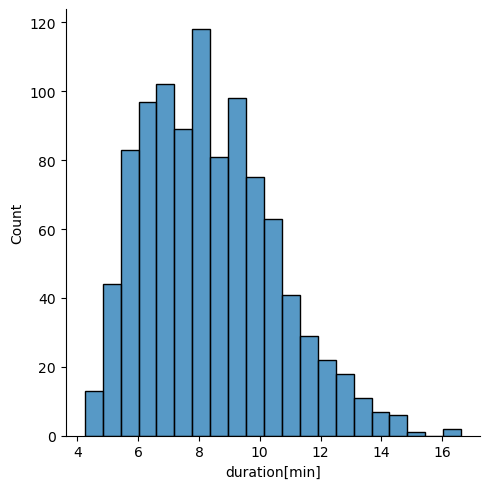

In [2]:
%matplotlib inline

import seaborn as sb

sb.displot(tiempos["duration[min]"])

# ¿Cómo se relacionan las variables entre si?

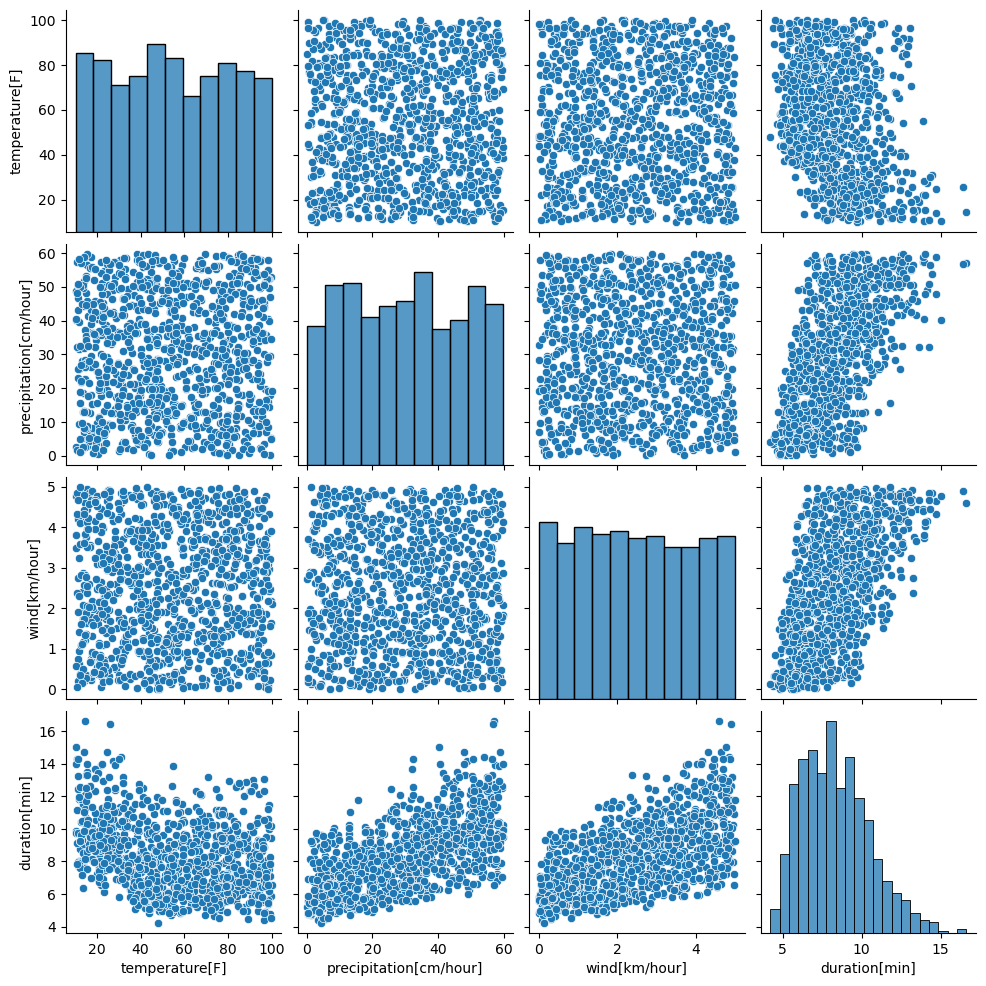

In [3]:
sb.pairplot(tiempos)

# ¿Incidencia de clima en tiempos de viaje (por variable)?

* ¿Será que alguna variable climática incide en los tiempos? 
* ¿Será que TODAS inciden? 
* ¿Qué tan bien puedo estimar tiempos a partir del clima?

## 1. Estimación mediante regresión lineal con *Statsmodels*

In [4]:
import statsmodels.api as sm

### Preparación de $X$ y $y$

Queremos construir:<br>

$y = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_3$

In [5]:
y = tiempos["duration[min]"]
X = tiempos.copy()
X.drop(["duration[min]"], axis=1, inplace=True)
X = sm.add_constant(X)

### Ajuste del modelo

In [6]:
modelo = sm.OLS(y, X)
resultado = modelo.fit()

### Presentación de resultados

In [7]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          duration[min]   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1711.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        06:44:04   Log-Likelihood:                -1269.8
No. Observations:                1000   AIC:                             2548.
Df Residuals:                     996   BIC:                             2567.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.3104      0.091     58.125      0.000       5.131       5.490
temperature[F]            -0.0275      0.001    -26.122      0.000      -0.030      -0.025
precipitation[cm/hour]     0.0796      0.002     50.013      0.000       0.076       0.083
wind[km/hour]              0.8805      0.019     46.598      0.000       0.843       0.918
==============================================================================
Omnibus:                        2.656   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.700
Skew:                           0.124   Prob(JB):                        0.259
Kurtosis:                       2.944   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Estimación mediante regresión lineal con *Scikit Learn*

### Preparación de $X$ y $y$

In [8]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = tiempos["duration[min]"]
X = tiempos.copy()
X.drop(["duration[min]"], axis=1, inplace=True)

### Entrenamiento

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

modelo = linear_model.LinearRegression()
modelo.fit( X_train.values, y_train.values )

print('Coefficients:\n \t\t'+str(modelo.intercept_)+"\t"+str(modelo.coef_) )

Coefficients:
 		5.30305046847216	[-0.0273791   0.07982587  0.87659118]


### "Predicción"

In [10]:
import numpy as np

nuevo_dato_clima = np.array([40, 50, 3]).reshape(1,-1)

prediccion = modelo.predict( nuevo_dato_clima )

prediccion

array([10.82895376])

### Prueba

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = modelo.predict( X_test.values )

print("Error medio cuadrático: \t%.2f"% mean_squared_error(y_test, y_pred))

print('R cuadrado: \t\t\t%.2f' % r2_score(y_test, y_pred))

Error medio cuadrático: 	0.77
R cuadrado: 			0.82
